In [8]:
 # установка лемматизатора pymorphy2
!pip install pymorphy2

In [9]:
import numpy as np # Библиотека для работы с массивами данных
from tensorflow.keras.models import Model, load_model # Импортируем модель, метод загрузки предобученной сети 
import re # Импортируем для работы со строками
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
# Импортируем слои для сеток
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D 
from tensorflow.keras.layers import BatchNormalization, Dropout, Conv2DTranspose, Lambda, LSTM, Flatten, GlobalAveragePooling1D
from tensorflow.keras import backend as K # Импортируем для подсчета dice_coef
from tensorflow.keras.optimizers import Adam, Adadelta # Импортируем оптимизаторы 
from tensorflow.keras import utils # Импортируем для работы с категориальными данными 
from google.colab import files # Импортируем для работы с файлами
import matplotlib.pyplot as plt # Импортируем для отрисовки графиков
from gensim.models import word2vec # Импортируем gensim 
import os # Импортируем для работы с файловой системой
import pandas as pd # И мпортируем для работы с DataFrame
import pymorphy2 # Импортируем для работы с леммами
import time # Импортируем для подсчета времени
import seaborn as sns
sns.set()
import random
from sys import getsizeof

In [10]:
# Подключаем диск
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
# Чтение файла текста из файла, очитска от знаков препинания
def readText(fileName):
  f = open(fileName, 'r') #Открываем наш файл для чтения и считываем из него данные 
  text = f.read() #Записываем прочитанный текст в переменную 
  # Определяем символы для удаления
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";"]

  for dS in delSymbols: # Каждый символ в списке символов для удаления
    text = text.replace(dS, " ") # Удаляем, заменяя на пробел

  # Ищем шаблоны и символы в строке и меняем на указанную подстроку
  text = re.sub("[.]", " ", text) 
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # Метод split разделит текст по пробелам (а их может быть несколько после удаления символов)
  # При помощи метода join запишем все разделенные слова снова в строку
  text = ' '.join(text.split()) 

  text = text.lower() # Переводим текст в нижний регистр
  return text # Возвращаем тексты

# Преобразование исходного текста в список из слов в нормальной форме 
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Создаем экземпляр класса MorphAnalyzer
  words = text.split(' ') # Разделяем текст на пробелы
  words = [morph.parse(word)[0].normal_form for word in words] #Переводим каждое слово в нормалную форму  
  return words # Возвращаем слова

# Собираем список индексов и dummy encoded вектора
def get01XSamples(tok_agreem, tags_index):
  tags01 = [] # Список для тегов
  indexes = [] # Здесь будут лежать индексы
 
  for agreement in tok_agreem: # Проходимся по каждому договору-списку
    tag_place = [0, 0, 0, 0, 0, 0] # Создаем вектор [0,0,0,0,0,0]
    for ex in agreement: # Проходимся по каждому слову договора
        if ex in tags_index: # Смотрим, если индекс оказался нашим тегом
          place = np.argwhere(tags_index==ex) # Записываем под каким местом лежит этот тег в своем списке
          if len(place)!=0: # Проверяем, чтобы тег действительно был
            if place[0][0]<6: # Первые шесть тегов в списке - открывающие
              tag_place[place[0][0]] = 1    # Поэтому ставим 1
            else: 
              tag_place[place[0][0] - 6] = 0  # Остальные теги закрывающие, так что меняем на ноль
        else:          
          tags01.append(tag_place.copy()) # Расширяем наш список с каждой итерацией. Получаем в конце длинный список из всех тегов в одном 
          indexes.append(ex) # Докидываем индекс слова в список индексов

  return indexes, tags01

# Получение списка слов из индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items())) # Берем пары значений всего словаря и размечаем наоборот, т.е. value:key
  words = [reverse_word_map.get(letter) for letter in x] # Вытаскиваем по каждому ключу в список
  return words # Возвращаем полученный текст

# Формируем выборку из индексов
def getSetFromIndexes(wordIndexes, xLen, step): 
  xBatch = [] # Лист для фрагментов текста
  wordsLen = len(wordIndexes) # Определяем длину текста
  index = 0 # Задаем стартовый индекс
  
  while (index + xLen <= wordsLen): # Пока сумма индекса с длинной фрагмента меньше или равна числу слов в выборке
    xBatch.append(wordIndexes[index:index+xLen]) # Добавляем X в лист фразментов текста
    index += step # Сдвигаемся на step

  return xBatch # Лист для фрагментов текста

# Создаем выборки
def getSets(model, senI, tagI):
  xVector = [] # Здесь будет лежать embedding представление каждого из индексов
  tmp = [] # Временный список
  for text in senI: # Проходимся по каждому тексту-списку
    tmp=[]
    for word in text: # Проходимся по каждому слову в тексте-списке
      tmp.append(model[word]) 

    xVector.append(tmp)

  return np.array(xVector), np.array(tagI)

def dice_coef(y_true, y_pred):
    return K.mean(y_true*y_pred + (1 - y_true)*(1 - y_pred))

 # Функция, выводящая точность распознавания каждой категории отдельно
def recognizeSet(tagI, pred, length, value):
  total=0
  tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
  for j in range(6): # общее количество тегов
    correct=0
    for i in range(len(tagI)): # проходимся по каждому списку списка тегов
      for k in range(length): # проходимся по каждому тегу
        if tagI[i][k][j]==(pred[i][k][j]>value).astype(int): # если соответствующие индексы совпадают, значит сеть распознала верно
          correct+=1 
    print("Сеть распознала категорию '%s' на %.2f%%" % (tags[j], 100*correct/(len(tagI)*length)))
    total += 100 * correct / (len(tagI)*length)
  print("Cредняя точность %.2f%%" % (total/6))   

In [12]:
directory = '/content/drive/My Drive/datasets/texts/Договора1000/'
agreements = [] # Список, в который запишем все наши договоры
for filename in os.listdir(directory): # Проходим по всем файлам в директории договоров
    txt = readText(directory + filename) # Читаем текст договора
    if txt != '': # Если текст не пустой
        agreements.append(readText(directory + filename))
words = [] # Здесь будут храниться все договора в виде списка слов
curTime = time.time() # Засечем текущее время
for i in range(len(agreements)): # Проходимся по всем договорам
    words.append(text2Words(agreements[i])) # Преобразуем очередной договор в список слов и добавляем в words
print('На преобразование ушло:', round(time.time() - curTime, 2), 'с.')

random.shuffle(words)
wordsToTest = words[-30:] # Возьмем 30 текстов для финальной проверки обученной нейронной сети 
words = words[:-30] 

tokenizer = Tokenizer(lower=True, filters='', char_level=False)

tokenizer.fit_on_texts(words) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
clean_voc = {} 

for item in tokenizer.word_index.items(): #Преобразуем полученный список 
    clean_voc[item[0]] = item[1]

tok_agreem = tokenizer.texts_to_sequences(words)

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # Получаем список открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # Получаем список закрывающих тегов
tags_index.extend(closetags) # Объединяем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем из словаря частотности индексы всех тегов
print('Индексы тегов:', tags_index)

xData, yData = get01XSamples(tok_agreem, tags_index) # Распознаем теги и создаем список с ними, с индексами
decoded_text = reverseIndex(clean_voc, xData) # Для создания списков с embedding-ами сначала преобразуем список индексов обратно в слова

xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300

xTrain = getSetFromIndexes(decoded_text, xLen, step) # Последовательность из xLen слов
yTrain = getSetFromIndexes(yData, xLen, step) # Последовательность из xLen-тегов

На преобразование ушло: 283.09 с.
Индексы тегов: [ 12 393  26  29 132 265  14 398  30  38 143 280]


In [13]:
# Проверка что число открывающихся тэгов равно числу закрывающихся.
counts = {}
for con in tok_agreem:
    for i in con:
        if i in tags_index:
            tag = tokenizer.index_word[i]
            if tag in counts.keys():
                counts[tag] += 1
            else:
                counts[tag] = 1

for i in range(1, 7):
    print ("<s%d>: %d, </s%d>: %d" % (i, counts['<s%d>' % i], i , counts['</s%d>' % i]))

<s1>: 8631, </s1>: 7946
<s2>: 367, </s2>: 360
<s3>: 4175, </s3>: 3855
<s4>: 3896, </s4>: 3471
<s5>: 1227, </s5>: 1099
<s6>: 618, </s6>: 570


In [14]:
# Функция для создания PSPnet-сети
def create_PSPNet(conv_size = 64, num_classes = 6, input_shape = (30, 300)):

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    img_input = Input(input_shape)

    # Block 1
    x = Conv1D(conv_size, 3, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(conv_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(x_mp_2,conv_size, 2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(x_mp_4,conv_size, 4, strides=4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(x_mp_8,conv_size, 8, strides=8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(x_mp_16,conv_size, 16, strides=16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(x_mp_32,conv_size, 32, strides=32)
    x_mp_32 = Activation('relu')(x_mp_32)


    fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adadelta(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

In [15]:
xLen = 256 # Длина окна
step = 30 # Шаг 
embeddingSize = 300
# pageSize = xLen
num_classes = 6
vocSize = len(tokenizer.index_word.items()) + 1
print(vocSize)

x_train = np.array(getSetFromIndexes(xData, xLen, step))
y_train = np.array(getSetFromIndexes(yData, xLen, step))
x_train.shape, y_train.shape

9006


((27731, 256), (27731, 256, 6))

In [16]:
inp = Input(shape=(xLen))
x = Embedding(vocSize, embeddingSize)(inp)
out = create_PSPNet(conv_size=256, input_shape=(xLen, embeddingSize))(x)

model = Model(inp, out)
model.compile(optimizer=Adam(0.0025), loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 256, 300)          2701800   
_________________________________________________________________
model (Functional)           (None, 256, 6)            6895622   
Total params: 9,597,422
Trainable params: 9,595,374
Non-trainable params: 2,048
_________________________________________________________________


Epoch 1/15
4992/4992 [==============================] - 144s 28ms/step - loss: 0.3071 - dice_coef: 0.8138 - val_loss: 0.3136 - val_dice_coef: 0.8388
Epoch 2/15
4992/4992 [==============================] - 135s 27ms/step - loss: 0.1651 - dice_coef: 0.9022 - val_loss: 0.3470 - val_dice_coef: 0.8811
Epoch 3/15
4992/4992 [==============================] - 135s 27ms/step - loss: 0.1015 - dice_coef: 0.9413 - val_loss: 0.3764 - val_dice_coef: 0.8704
Epoch 4/15
4992/4992 [==============================] - 135s 27ms/step - loss: 0.0697 - dice_coef: 0.9604 - val_loss: 0.4548 - val_dice_coef: 0.8771
Epoch 5/15
4992/4992 [==============================] - 137s 27ms/step - loss: 0.0519 - dice_coef: 0.9709 - val_loss: 0.5069 - val_dice_coef: 0.8892
Epoch 6/15
4992/4992 [==============================] - 136s 27ms/step - loss: 0.0407 - dice_coef: 0.9773 - val_loss: 0.5200 - val_dice_coef: 0.8801
Epoch 7/15
4992/4992 [==============================] - 137s 27ms/step - loss: 0.0340 - dice_coef: 0.9810 

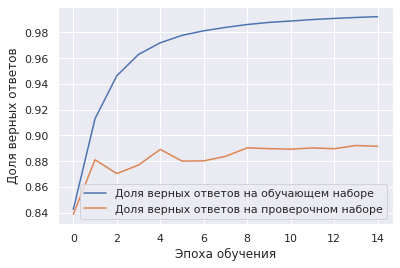

In [17]:
history = model.fit(x_train, y_train, epochs=15, batch_size=5, validation_split=0.1)

plt.plot(history.history['dice_coef'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_dice_coef'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [18]:
# Подготовим тестовые данные:
tok_agreem2 = tokenizer.texts_to_sequences(wordsToTest)

xData2, yData2 = get01XSamples(tok_agreem2, tags_index)
x_test = np.array(getSetFromIndexes(xData2, xLen, step))
y_test = np.array(getSetFromIndexes(yData2, xLen, step))
x_test.shape, y_test.shape

((924, 256), (924, 256, 6))

In [19]:
score = model.evaluate(x_test, y_test)
score

29/29 [==============================] - 1s 17ms/step - loss: 0.6512 - dice_coef: 0.9036


[0.651188313961029, 0.9036383032798767]

In [20]:
pred = model.predict(x_test)
recognizeSet(y_test, pred, xLen, 0.5)

Сеть распознала категорию 'S1' на 76.29%
Сеть распознала категорию 'S2' на 99.22%
Сеть распознала категорию 'S3' на 87.13%
Сеть распознала категорию 'S4' на 88.08%
Сеть распознала категорию 'S5' на 95.71%
Сеть распознала категорию 'S6' на 97.17%
Cредняя точность 90.60%
